# General Imports

In [ ]:
# 0.2.0.01 Required: Load the libraries

import os 
import socket
import traceback
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #This is to shut off the GPU (like if your computer doesn't have one)
import shutil
from pathlib import Path
import time
from datetime import datetime
import math
import types
from random import randint
from IPython.display import clear_output
import re #regular Expressions
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf



def get_folder_size(folder):
    total = 0
    for path, dirs, files in os.walk(folder):
        for f in files:
            fp = os.path.join(path, f)
            total += os.path.getsize(fp)
    return total

#import warnings  #import logging
#warnings.filterwarnings("ignore", message=".*Using a while_loop for converting.*", category=UserWarning)
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'; tf_logger = tf.get_logger(); tf_logger.setLevel(logging.WARNING)

from tensorflow import keras
import seaborn as sns
import umap.umap_ as umap
import tf2onnx


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree
from scipy.stats import kruskal

cfg = tf.config.list_logical_devices()

print("TensorFlow version: ", tf.__version__)
print("CUDA version: ", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN version: ", tf.sysconfig.get_build_info()['cudnn_version'])

In [ ]:
### read image 
### instantiate each object
## watershed to draw boundaries
### export as rle or polygon

252


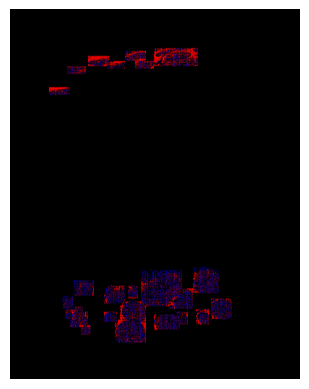

In [20]:
# read image and display
image_path = r"S:\Phys\FIV925 XSection\MIP\20230825 Full final.png"
image = cv2.imread(image_path)
print(image.max())

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# convert the image to grayscale and threshold to get axons
axon_channel = image[:,:,2]
gray = axon_channel.copy()

_, axon_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(axon_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

axon_instances = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"]!= 0:
        cX = int(M["m10"]/M["m00"])
        cY = int(M["m01"]/M["m00"])

        axon_instances.append((cX, cY))

axon_plot = image.copy()

for(cX, cY) in axon_instances:
    cv2.circle(axon_plot, (cX, cY), 10, (0,255,0), -1)
## plot circles around center of axons

plt.imshow(cv2.cvtColor(axon_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## print list of axon centers and x,y coordinates
for idx, (x,y) in enumerate(axon_instances, start =1):
    print(f"Instance {idx}: (x, y) = ({x}, {y})")



In [ ]:
## watershed to group axons 
marker = np.zeros_like(axon_mask, dtype = np.int32)

for i, contour in enumerate(contours):
    cv2.drawContours(marker, [contour], 0, i+1, -1)

#if len(image.shape) != 3 or image.shape[2] != 3:
#    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

print("watershedding now. . .")
cv2.watershed(image, marker)

plt.imshow(marker, cmap="tab20b")
plt.show()

In [ ]:
print("calculating rle boundaries . . .")
boundary_image = np.zeros_like(image, dtype=np.uint8)
colors = np.random.randint(0,255,size=(len(contours),3))

for i in range(len(contours)):
    boundary_image[marker== i+1] = colors[i]

print("plotting everything. . .")
plt.imshow(boundary_image)
plt.title("RLE cell boundaries")
plt.axis("off")
plt.show()

In [ ]:
### using DigitalSeerani method ### this works for instantiating the axonal regions 11/6
import cv2
import numpy as np 
from matplotlib import pyplot as plt 
from scipy import ndimage 
from skimage import measure, color, io


# read image and display
image_path = r"S:\Phys\FIV925 XSection\MIP\1011 00134 Inference\single fascicle.png"
img1 = cv2.imread(image_path)
img = img1[:,:,0] ### only look at blue channel (axons)

#img = img1[:,:,0]
#print(img.max())
#plt.imshow(img)

# binary OTSU thresholding 
ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

## remove holes
kernel =np.ones((3,3), np.uint8) ## kernel to sharpen image
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

## now we want to identify sure bg areas. Dilate pixels a few times to increase cell boundary to background
sure_bg = cv2.dilate(opening, kernel, iterations =2)

# distance transform --> replace pixel values with distance to closes background pixel. 
# create distance map
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,3)

# threshod dist transform; identify SEEDS for the wtaerhsed transform
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)

# ambiguous region is sure background - sure foreground (seeds)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

## now deifne markers. bg anf fg labled with positive number. unknown is labeled as 0
ret3, markers = cv2.connectedComponents(sure_fg)

# add 10 to all markers so bg is not 0 but 10 
markers = markers+10

# now define unknown, marked as 0
markers[unknown==255] = 0

# now watershed filling
markers = cv2.watershed(img1, markers)
# boundaries in yellow
img1[markers ==-1] = [0, 255, 255]

img2 = color.label2rgb(markers, bg_label=0)

plt.imshow(img2)
plt.axis("off")
plt.show()

## now, extract some features about the detected objects
regions = measure.regionprops(markers, intensity_image = img)

for prop in regions:
    print("Label: {} Area: {}".format(prop.label, prop.area))


In [ ]:
# great, I have created separate instances for each object. now I want to rle encode these
### using DigitalSeerani method ### this works for instantiating the axonal regions 11/6
### works great 11/15
import cv2
import numpy as np 
from matplotlib import pyplot as plt 
from scipy import ndimage 
from skimage import measure, color, io
from skimage.morphology import binary_dilation
from skimage.measure import label, regionprops
from skimage.util import img_as_ubyte
import skimage
import csv
from shapely.geometry import Polygon
from shapely.geometry import mapping


csv_file_path= r"S:\Phys\FIV925 XSection\MIP\1011 00134 Inference\polygon_masks.csv"

# read image and display
image_path = r"S:\Phys\FIV925 XSection\MIP\1011 00134 Inference\single fascicle.png"
img1 = cv2.imread(image_path)
img = img1[:,:,0] ### only look at blue channel (axons)


# binary OTSU thresholding 
_, pre_thresh = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

ret1, thresh = cv2.threshold(pre_thresh, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

## remove holes
kernel =np.ones((3,3), np.uint8) ## kernel to sharpen image
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

## now we want to identify sure bg areas. Dilate pixels a few times to increase cell boundary to background
sure_bg = cv2.dilate(opening, kernel, iterations =2)

# distance transform --> replace pixel values with distance to closes background pixel. 
# create distance map
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,3)

# threshod dist transform; identify SEEDS for the wtaerhsed transform
ret2, sure_fg = cv2.threshold(dist_transform, 0.05*dist_transform.max(),255,0)

# ambiguous region is sure background - sure foreground (seeds)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

## now deifne markers. bg anf fg labled with positive number. unknown is labeled as 0
ret3, markers = cv2.connectedComponents(sure_fg)

# add 10 to all markers so bg is not 0 but 10 
markers = markers+10

# now define unknown, marked as 0
markers[unknown==255] = 0

# now watershed filling
markers = cv2.watershed(img1, markers)
# boundaries in yellow
img1[markers ==-1] = [0, 255, 255]

unique_markers = np.unique(markers)
colored_segmentation = np.zeros_like(img1)

for marker in unique_markers:
    if marker == 10:
        continue 
    colored_segmentation[markers == marker] = np.random.randint(0,255, size =3)

alpha = 0.5
#overlay_color = np.array([0,0,255], dtype = np.uint8)
#img2_colored = np.where(img2_color == 255, overlay_color, img2_color).astype(np.uint8)
#img_color = img_color.astype(np.uint8)
overlay = cv2.addWeighted(img1, alpha, colored_segmentation, 1 - alpha, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


## now, extract some features about the detected objects
regions = measure.regionprops(markers, intensity_image = img)

for prop in regions:
    print("Label: {} Area: {}".format(prop.label, prop.area))

### now polygon encode
polygon_masks = []

print("calculating polygon masks.. ")
for region in regions:
    mask = np.zeros_like(markers, dtype=np.uint8)
    mask[markers == region.label] = 1
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = [contour for contour in contours if len(contour) >= 4]

    polygons = [Polygon(contour.reshape(-1,2)) for contour in valid_contours]

    polygon_mapping = [mapping(polygon) for polygon in polygons]

    polygon_masks.append(polygon_mapping)


with open(csv_file_path, "w", newline = "") as csvfile:
    writer = csv.writer(csvfile)
    for i, polygon_mask in enumerate(polygon_masks):
        writer.writerow([f"Instance {i + 1}", str(polygon_mask)])

print("done")


# Watershed, works 11/29

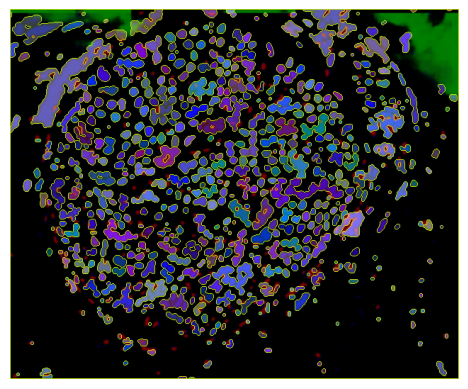

Label: 1 Area: 233051.0
Label: 2 Area: 672.0
Label: 3 Area: 160.0
Label: 4 Area: 85.0
Label: 5 Area: 1883.0
Label: 6 Area: 17.0
Label: 7 Area: 5.0
Label: 8 Area: 6.0
Label: 9 Area: 14.0
Label: 10 Area: 37.0
Label: 11 Area: 9.0
Label: 12 Area: 14.0
Label: 13 Area: 1313.0
Label: 14 Area: 22.0
Label: 15 Area: 17.0
Label: 16 Area: 84.0
Label: 17 Area: 347.0
Label: 18 Area: 20.0
Label: 19 Area: 199.0
Label: 20 Area: 12.0
Label: 21 Area: 27.0
Label: 22 Area: 118.0
Label: 23 Area: 31.0
Label: 24 Area: 27.0
Label: 25 Area: 87.0
Label: 26 Area: 139.0
Label: 27 Area: 35.0
Label: 28 Area: 27.0
Label: 29 Area: 127.0
Label: 30 Area: 150.0
Label: 31 Area: 268.0
Label: 32 Area: 15.0
Label: 33 Area: 267.0
Label: 34 Area: 136.0
Label: 35 Area: 104.0
Label: 36 Area: 19.0
Label: 37 Area: 442.0
Label: 38 Area: 57.0
Label: 39 Area: 813.0
Label: 40 Area: 95.0
Label: 41 Area: 3672.0
Label: 42 Area: 121.0
Label: 43 Area: 98.0
Label: 44 Area: 79.0
Label: 45 Area: 77.0
Label: 46 Area: 35.0
Label: 47 Area: 128.0

In [2]:
### full watershed

import cv2
import numpy as np 
from matplotlib import pyplot as plt 
from scipy import ndimage 
from skimage import measure, color, io
from skimage.morphology import binary_dilation
from skimage.measure import label, regionprops
from skimage.util import img_as_ubyte
import skimage
import csv
from shapely.geometry import Polygon
from shapely.geometry import mapping


csv_file_path= r"S:\Phys\FIV925 XSection\MIP\1011 00134 Inference\polygon_masks.csv"

# read image and display
image_path = r"S:\Phys\FIV925 XSection\MIP\1011 00134 Inference\single fascicle.png"
img1 = cv2.imread(image_path)
img = img1[:,:,0] ### only look at blue channel (axons)


# binary OTSU thresholding 
_, pre_thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

ret1, thresh = cv2.threshold(pre_thresh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

## remove holes
kernel =np.ones((3,3), np.uint8) ## kernel to sharpen image
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) ## higher opening will eliminate objects

## now we want to identify sure bg areas. Dilate pixels a few times to increase cell boundary to background
sure_bg = cv2.dilate(opening, kernel, iterations =1) ## higher dilations will join objects

# distance transform --> replace pixel values with distance to closes background pixel. 
# create distance map
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,3)

# threshod dist transform; identify SEEDS for the watershed transform
ret2, sure_fg = cv2.threshold(dist_transform, 0.05*dist_transform.max(),255,0)

# ambiguous region is sure background - sure foreground (seeds)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

## now deifne markers. bg anf fg labled with positive number. unknown is labeled as 0
ret3, markers = cv2.connectedComponents(sure_fg)

# add 10 to all markers so bg is not 0 but 10 
markers = markers+10

# now define unknown, marked as 0
markers[unknown==255] = 0

# now watershed filling
markers = cv2.watershed(img1, markers)
# boundaries in yellow
img1[markers ==-1] = [0, 255, 255]

unique_markers = np.unique(markers)
colored_segmentation = np.zeros_like(img1)

for marker in unique_markers:
    if marker == 10:
        continue 
    colored_segmentation[markers == marker] = np.random.randint(0,255, size =3)

alpha = 0.5
#overlay_color = np.array([0,0,255], dtype = np.uint8)
#img2_colored = np.where(img2_color == 255, overlay_color, img2_color).astype(np.uint8)
#img_color = img_color.astype(np.uint8)
overlay = cv2.addWeighted(img1, alpha, colored_segmentation, 1 - alpha, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


## now, extract some features about the detected objects
regions = measure.regionprops(markers, intensity_image = img)

for i, prop in enumerate(regions):
    print("Label: {} Area: {}".format(i + 1, prop.area))

### now polygon encode
polygon_masks = []

print("calculating polygon masks.. ")
for region in regions:
    mask = np.zeros_like(markers, dtype=np.uint8)
    mask[markers == region.label] = 1
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = [contour for contour in contours if len(contour) >= 4]
    polygons = []
    for contour in valid_contours:
        polygon = Polygon(contour.reshape(-1,2))

        if polygon.area < 2000:
            polygon_mapping = mapping(polygon)
            polygons.append(polygon_mapping)


    polygon_masks.append(polygons)


with open(csv_file_path, "w", newline = "") as csvfile:
    writer = csv.writer(csvfile)
    for i, polygon_mask in enumerate(polygon_masks):
        writer.writerow([f"AxonID {i}", str(polygon_mask)])

print("done")


### Identify fascicle rings

In [ ]:
#image = r"S:\Phys\FIV925 XSection\Fascicles\02c\segment\0001.bmp"
# Read the image
img = cv2.imread(r"S:\Phys\FIV925 XSection\Fascicles\02c\segment\0001.bmp")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# binarize the image
thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)[1]

# find external contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
for i, contour in enumerate(contours[:5]):
    print(f"Contour {i+1}:", contour)

print("total contours found:", len(contours))